In [25]:
from lib import data_loaders
from dotenv import load_dotenv
import os
import requests
import pandas as pd

In [6]:
load_dotenv()
dendra_pass = os.getenv("DENDRA_PASS")

In [7]:
# initialize Dendra class w/ user & pass
DendraClient = data_loaders.Dendra(email="dragar@lynker.com", password=dendra_pass)

successfully authenticated


In [86]:
# Example parameters
min_dt = pd.to_datetime("2016-01-01")
max_dt = pd.to_datetime("2020-01-01")


res = DendraClient.get_datapoints(
    start=min_dt,
    end=max_dt,
    datastream_name="Well Water Level xle/lev",
    station_id="64dbe9ca5c0d5f0fd8694a9f",
)

# Note to keep an eye on the units, as water level data has outliers (device removal from well), which
# is much greater magnitude than data signal

<Axes: xlabel='datetime'>

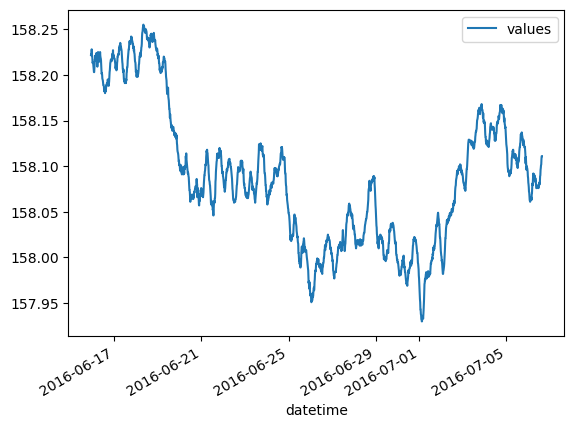

In [92]:
# Note to keep an eye on the units, as water level data has outliers (device removal from well or similar), which
# is much greater magnitude than data signal. Indexing out first 10 timestamps here.
res.iloc[10:].plot()